In [13]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression, Perceptron
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [3]:
columns = [f'pixel_{i}' for i in range(1296)]
columns.append('label')
df = pd.DataFrame(columns=columns)

car_types = ['Hatchback', 'Pickup', 'Seden', 'SUV']
for cartype in car_types:
    path = f'./test_image/{cartype}/'
    for i in range(1500):
        try:
            image = f'PHOTO_{i}.jpg'
            image_path = path + image

            image = Image.open(image_path).convert("L")
            image = image.resize((36, 36), Image.ADAPTIVE)
            pixel_values = np.array(image).reshape(-1)
            normalized_pixel_values = pixel_values / 255
            row_data = np.concatenate([normalized_pixel_values, [cartype]])
            ndf = pd.DataFrame([row_data], columns=columns)
            df = pd.concat([df, ndf], ignore_index=True)   
        except FileNotFoundError as e:
            continue
    
    

df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_1287,pixel_1288,pixel_1289,pixel_1290,pixel_1291,pixel_1292,pixel_1293,pixel_1294,pixel_1295,label
0,0.6588235294117647,0.3803921568627451,0.3254901960784314,0.5843137254901961,0.6745098039215687,0.7372549019607844,0.7607843137254902,0.7411764705882353,0.807843137254902,0.8941176470588236,...,0.0392156862745098,0.12941176470588237,0.1803921568627451,0.24705882352941178,0.0784313725490196,0.058823529411764705,0.047058823529411764,0.4117647058823529,0.592156862745098,Hatchback
1,0.5607843137254902,0.24705882352941178,0.22745098039215686,0.21176470588235294,0.42745098039215684,0.5882352941176471,0.5607843137254902,0.5254901960784314,0.5254901960784314,0.5333333333333333,...,0.054901960784313725,0.054901960784313725,0.047058823529411764,0.058823529411764705,0.4235294117647059,0.48627450980392156,0.03137254901960784,0.08235294117647059,0.11372549019607843,Hatchback
2,0.2784313725490196,0.2823529411764706,0.27450980392156865,0.38823529411764707,0.7450980392156863,0.7411764705882353,0.7803921568627451,0.5686274509803921,0.4980392156862745,0.5529411764705883,...,0.058823529411764705,0.058823529411764705,0.06666666666666667,0.06666666666666667,0.08235294117647059,0.09411764705882353,0.1450980392156863,0.38823529411764707,0.5019607843137255,Hatchback
3,0.8666666666666667,0.7764705882352941,0.8274509803921568,0.8784313725490196,0.9254901960784314,0.9568627450980393,0.8823529411764706,0.792156862745098,0.7843137254901961,0.796078431372549,...,0.9019607843137255,0.8745098039215686,0.8941176470588236,0.8313725490196079,0.7490196078431373,0.7803921568627451,0.8,0.7647058823529411,0.7647058823529411,Hatchback
4,0.6823529411764706,0.7294117647058823,0.4745098039215686,0.6,0.7333333333333333,0.6901960784313725,0.6941176470588235,0.7647058823529411,0.7686274509803922,0.792156862745098,...,0.1843137254901961,0.21176470588235294,0.21568627450980393,0.23137254901960785,0.2549019607843137,0.2627450980392157,0.2784313725490196,0.29411764705882354,0.35294117647058826,Hatchback


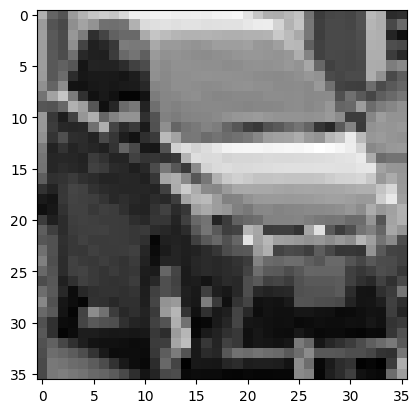

In [4]:

imagepath = 'test_image/Hatchback/PHOTO_0.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [5]:
df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_1287,pixel_1288,pixel_1289,pixel_1290,pixel_1291,pixel_1292,pixel_1293,pixel_1294,pixel_1295,label
0,0.6588235294117647,0.3803921568627451,0.3254901960784314,0.5843137254901961,0.6745098039215687,0.7372549019607844,0.7607843137254902,0.7411764705882353,0.807843137254902,0.8941176470588236,...,0.0392156862745098,0.12941176470588237,0.1803921568627451,0.24705882352941178,0.0784313725490196,0.058823529411764705,0.047058823529411764,0.4117647058823529,0.592156862745098,Hatchback
1,0.5607843137254902,0.24705882352941178,0.22745098039215686,0.21176470588235294,0.42745098039215684,0.5882352941176471,0.5607843137254902,0.5254901960784314,0.5254901960784314,0.5333333333333333,...,0.054901960784313725,0.054901960784313725,0.047058823529411764,0.058823529411764705,0.4235294117647059,0.48627450980392156,0.03137254901960784,0.08235294117647059,0.11372549019607843,Hatchback
2,0.2784313725490196,0.2823529411764706,0.27450980392156865,0.38823529411764707,0.7450980392156863,0.7411764705882353,0.7803921568627451,0.5686274509803921,0.4980392156862745,0.5529411764705883,...,0.058823529411764705,0.058823529411764705,0.06666666666666667,0.06666666666666667,0.08235294117647059,0.09411764705882353,0.1450980392156863,0.38823529411764707,0.5019607843137255,Hatchback
3,0.8666666666666667,0.7764705882352941,0.8274509803921568,0.8784313725490196,0.9254901960784314,0.9568627450980393,0.8823529411764706,0.792156862745098,0.7843137254901961,0.796078431372549,...,0.9019607843137255,0.8745098039215686,0.8941176470588236,0.8313725490196079,0.7490196078431373,0.7803921568627451,0.8,0.7647058823529411,0.7647058823529411,Hatchback
4,0.6823529411764706,0.7294117647058823,0.4745098039215686,0.6,0.7333333333333333,0.6901960784313725,0.6941176470588235,0.7647058823529411,0.7686274509803922,0.792156862745098,...,0.1843137254901961,0.21176470588235294,0.21568627450980393,0.23137254901960785,0.2549019607843137,0.2627450980392157,0.2784313725490196,0.29411764705882354,0.35294117647058826,Hatchback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,0.6078431372549019,0.6,0.5725490196078431,0.5333333333333333,0.5137254901960784,0.4980392156862745,0.4588235294117647,0.2980392156862745,0.23529411764705882,0.37254901960784315,...,0.22745098039215686,0.25882352941176473,0.27450980392156865,0.3058823529411765,0.3607843137254902,0.40784313725490196,0.4549019607843137,0.49411764705882355,0.5137254901960784,SUV
3658,0.9686274509803922,0.984313725490196,0.9019607843137255,0.6980392156862745,0.49411764705882355,0.3843137254901961,0.40784313725490196,0.611764705882353,0.7607843137254902,0.8588235294117647,...,0.15294117647058825,0.19607843137254902,0.16862745098039217,0.1843137254901961,0.23137254901960785,0.2980392156862745,0.37254901960784315,0.403921568627451,0.4588235294117647,SUV
3659,0.6235294117647059,0.6078431372549019,0.6078431372549019,0.5764705882352941,0.5411764705882353,0.5176470588235295,0.47843137254901963,0.47058823529411764,0.3058823529411765,0.26666666666666666,...,0.16470588235294117,0.1843137254901961,0.21176470588235294,0.25098039215686274,0.29411764705882354,0.3411764705882353,0.41568627450980394,0.49411764705882355,0.5294117647058824,SUV
3660,0.7450980392156863,0.792156862745098,0.8235294117647058,0.8431372549019608,0.8901960784313725,0.9137254901960784,0.9019607843137255,0.8901960784313725,0.9058823529411765,0.8313725490196079,...,0.13333333333333333,0.1607843137254902,0.17647058823529413,0.19215686274509805,0.22745098039215686,0.24705882352941178,0.2823529411764706,0.3254901960784314,0.34901960784313724,SUV


In [6]:
df.to_csv('new_image_dataset_36pixels.csv', index=False)

In [41]:
df = pd.read_csv('new_image_dataset_36pixels.csv')

In [42]:
newdf = df.copy()
newdf['label'] = newdf['label'].replace({'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3})

In [43]:
X = newdf.drop('label', axis=1)
y = newdf['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# lc = LazyClassifier()
# models, predictions = lc.fit(X_train, X_test, y_train, y_test)
# models

In [45]:
# models.to_csv('newmodels_choice.csv')

In [67]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [68]:
confusion_matrix(y_test, y_pred)

array([[194,   3,   5,   5],
       [  0, 334,   0,   0],
       [  0,   0, 364,   0],
       [  0,   0,   0, 194]])

In [69]:
clf.score(X_train, y_train)

1.0

In [70]:
clf.score(X_test, y_test)

0.9881710646041856

In [180]:
# save model
import pickle
pickle.dump(clf, open('./car_detection_model.pkl', 'wb'))

testing images

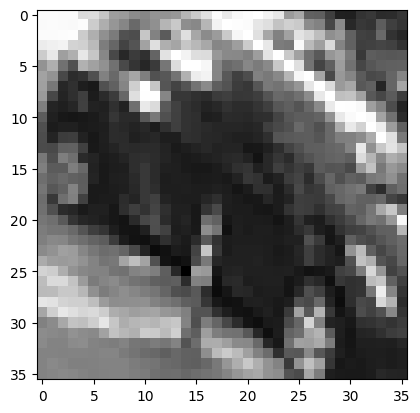

In [62]:
imagepath = 'test_image/Hatchback/PHOTO_342.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [63]:
columns = [f'pixel_{i}' for i in range(1296)]

In [65]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [71]:
clf.predict(ndf)

array([0])

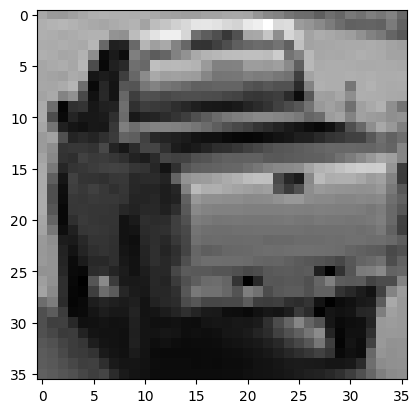

In [72]:
imagepath = 'test_image/Pickup/PHOTO_342.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [73]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [74]:
clf.predict(ndf)

array([1])

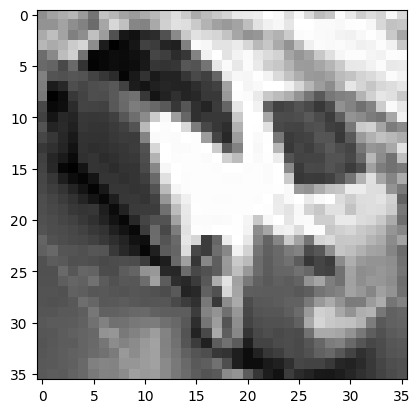

In [75]:
imagepath = 'test_image/Seden/PHOTO_548.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [76]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [77]:
clf.predict(ndf)

array([2])

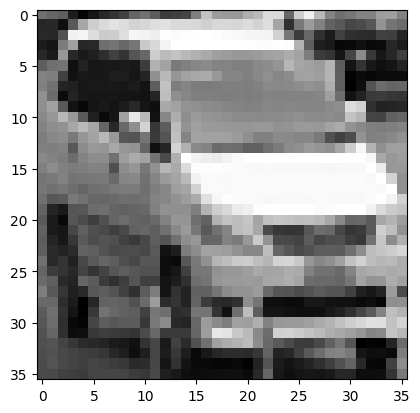

In [79]:
imagepath = 'test_image/SUV/PHOTO_123.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [80]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

In [81]:
clf.predict(ndf)

array([3])

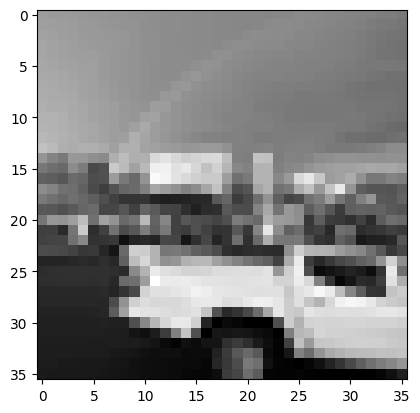

In [91]:
imagepath = 'pickup.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [92]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [93]:
clf.predict(ndf)

array([1])

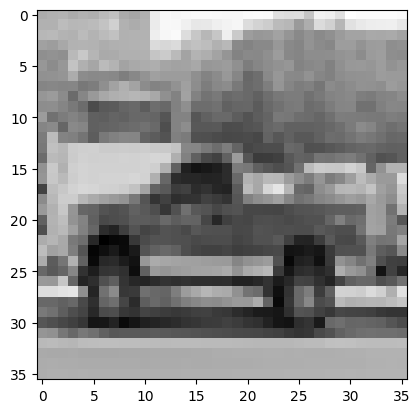

In [97]:
imagepath = 'pickup2.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [98]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [99]:
clf.predict(ndf)

array([1])

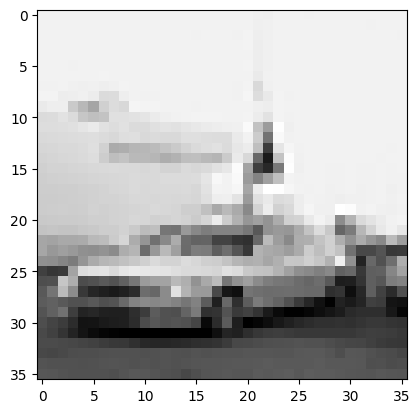

In [103]:
imagepath = 'sedan.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [104]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [105]:
clf.predict(ndf)

array([2])

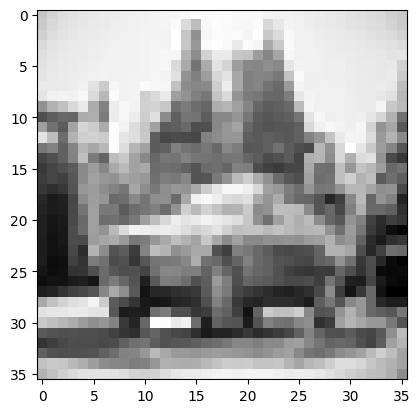

In [111]:
imagepath = 'sedan2.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [112]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [113]:
clf.predict(ndf)

array([2])

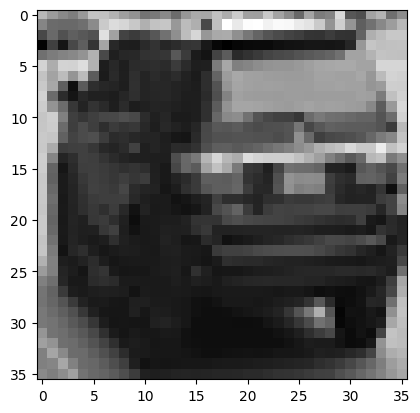

In [153]:
imagepath = 'suv.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [154]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [155]:
clf.predict(ndf)

array([3])

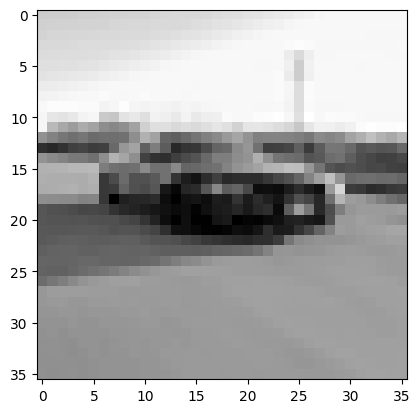

In [190]:
imagepath = 'unknown.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [191]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [192]:
clf.predict(ndf)

array([2])